# Train a neural network (gaussian noise during training)

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Set seeds

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

Set parameters

In [3]:
# file with training input and output data: format is x,y
input_file = 'training.csv'

# names of input/output columns
inputs = ['mu', 'angle', 'threshold']
outputs = ['low_speed', 'high_speed']

# these set the input/output dimensions of the network
input_size = len(inputs)
output_size = len(outputs)

Read data

In [4]:
data = pd.read_csv(input_file)
data.columns = inputs + outputs

x = np.array(data[inputs])
y = np.array(data[outputs])

Normalizing preprocessing layer from training data

In [5]:
normalizer = keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(x)

Penalize overpredictions more than underpredictions

In [6]:
def asymmetric_mse(y_true, y_pred):
    standard_mse = keras.losses.mse(y_true, y_pred)
    geq = keras.backend.any(keras.backend.greater(y_pred, y_true)) # true/false, are there overpredictions?
    geq_scale = keras.backend.switch(geq,5.0,1.0) # if there are overpredictions, scale up mse
    return geq_scale * standard_mse

Base model

In [7]:
input_shape = x.shape[1:]
full_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(full_model_input)
noise_layer = keras.layers.GaussianNoise(0.025)(normalized_input,training=True)
dense_layer = keras.layers.Dense(20, activation='relu')(noise_layer)
full_model_output = keras.layers.Dense(output_size,activation='relu')(dense_layer)
full_model = keras.Model(full_model_input, full_model_output)
full_model.compile(loss='mse',optimizer='adam',metrics=['mse'])

Compile model

Split data

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33, shuffle= True)

Train model

In [9]:
model_output = full_model.fit(x_train,y_train,epochs=600,batch_size=10,verbose=0,validation_data=(x_val,y_val)) # check validation

View training

<Figure size 432x288 with 0 Axes>

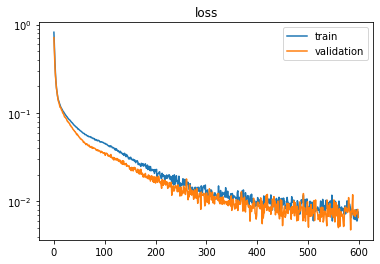

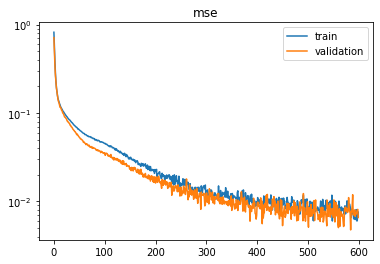

<Figure size 432x288 with 0 Axes>

In [10]:
plt.yscale('log')
plt.title('loss')
plt.plot(model_output.history['loss'], label='train')
plt.plot(model_output.history['val_loss'], label='validation')
plt.legend()
plt.figure()
plt.yscale('log')
plt.title('mse')
plt.plot(model_output.history['mse'], label='train')
plt.plot(model_output.history['val_mse'], label='validation')
plt.legend()
plt.figure()

View output

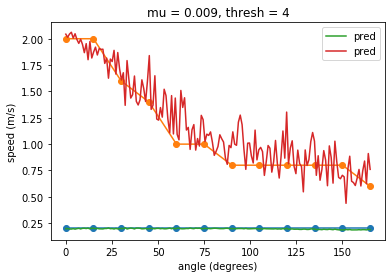

In [11]:
# plot speed vs angle given mu, threshold
mu = 0.009 # set mu
thresh = 4 # set threshold

# bug: mu = 0.009 is read as 0.0090..01
#plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == thresh] # x, y
# this is not generic enough...
pred_x = [[mu,angle,thresh] for angle in np.linspace(0,165,165)]
pred = full_model.predict(pred_x)

plt.title('mu = %s, thresh = %s' % (mu, thresh))
plt.xlabel('angle (degrees)')
plt.ylabel('speed (m/s)')
#plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
plt.plot([i[1] for i in plot_x], [y[i] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == thresh], marker='o')
plt.plot([i[1] for i in pred_x], pred, label='pred')
plt.legend()

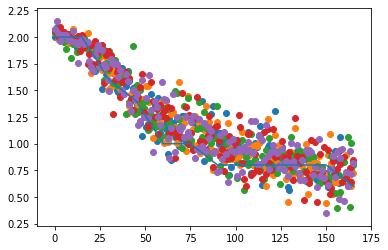

In [12]:
# plot speed vs angle given mu, threshold
mu = 0.009 # set mu
thresh = 4 # set threshold

# bug: mu = 0.009 is read as 0.0090..01
#plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
for i in range(0, 5):
    plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == thresh] # x, y
    # this is not generic enough...
    pred_x = [[mu,angle,thresh] for angle in np.linspace(0,165,165)]
    pred = full_model.predict(pred_x)
    plt.scatter([i[1] for i in pred_x], pred[...,1])
plt.plot([i[1] for i in plot_x], [y[i][1] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == thresh], label='train')

Save model

In [13]:
full_model.save("gaussian_training_network.h5")

Find largest divergence between prediction and training data

In [14]:
# divergence = (full_model.predict(x) - y)
# max_divergence = max([i[1] for i in divergence])
# print(max_divergence)
# print(max_divergence, x[np.where(divergence == max_divergence)[0]])

Time the network

In [15]:
%%timeit time_x = np.array(np.random.rand(1,3))
full_model.predict(time_x)

15.1 ms ± 261 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit time_x = np.array(np.random.rand(10,3))
full_model.predict(time_x)

14.8 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit time_x = np.array(np.random.rand(100,3))
full_model.predict(time_x)

16.1 ms ± 301 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Prediction network

Find the largest variance

(array([ 1.,  3., 13., 15., 19., 17., 12.,  8.,  6.,  6.]),
 array([0.02808584, 0.02892601, 0.02976618, 0.03060635, 0.03144652,
        0.03228669, 0.03312686, 0.03396703, 0.0348072 , 0.03564737,
        0.03648754], dtype=float32),
 <a list of 10 Patch objects>)

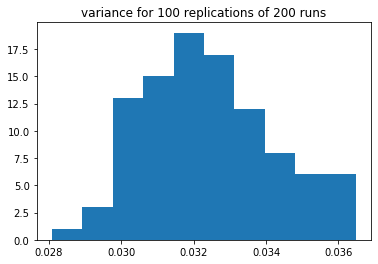

In [18]:
deviations = []
means = []
replications = 100 # number of variances
runs = 100 # number of runs per replication for variance calculation

for i in range(0, replications):
    predictions = []
    for i in range(0, runs):
        predictions.append(full_model.predict(pred_x)[...,1])
    predictions = np.array(predictions)
    deviations.append(max(predictions.var(axis = 0, ddof=1))) # unbiased estimator

plt.title('variance for %i replications of %i runs' % (replications, runs))
plt.hist(deviations)

In [14]:
standard_deviation = max(deviations)**0.5 # sqrt max variance from previous step
print(standard_deviation)

0.20173501387199433


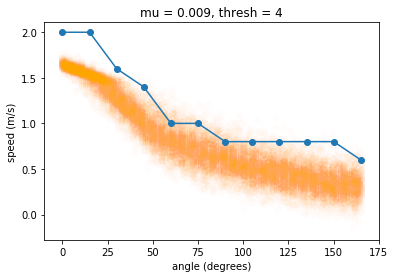

In [15]:
# plot speed vs angle given mu, threshold with variance
mu = 0.009 # set mu
thresh = 4 # set threshold
plot_deviation = standard_deviation*2 # 2 std

# bug: mu = 0.009 is read as 0.0090..01
plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == thresh] # x, y
# this is not generic enough...
pred_x = [[mu,angle,thresh] for angle in np.linspace(0,165,165)]

plt.title('mu = %s, thresh = %s' % (mu, thresh))
plt.xlabel('angle (degrees)')
plt.ylabel('speed (m/s)')
#plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
plt.plot([i[1] for i in plot_x], [y[i][1] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == thresh], marker='o')
#plt.scatter([i[1] for i in pred_x], pred[...,1], label='pred')
#plt.scatter([i[1] for i in pred_x], pred[...,1]-plot_deviation, label='pred - std')
for i in range(0, 100):
    pred = full_model.predict(pred_x)
    plt.scatter([i[1] for i in pred_x], pred[...,1]-plot_deviation, c='orange', alpha=0.01)

In [16]:
subtract_value = tf.convert_to_tensor([standard_deviation*2]) # subtract 2 std from predictions

weights = [layer.get_weights() for layer in full_model.layers]

input_shape = x.shape[1:]
prediction_model_input = keras.Input(shape=input_shape)
normalized_input = normalizer(prediction_model_input)
noise_layer = keras.layers.GaussianNoise(0.05)(normalized_input,training=False)
dense_layer = keras.layers.Dense(20, activation='relu')(noise_layer)
prediction_model_output = keras.layers.Dense(output_size,activation='relu')(dense_layer)
prediction_model_subtract = keras.layers.Subtract()([prediction_model_output, subtract_value])
prediction_model = keras.Model(prediction_model_input, prediction_model_subtract)
prediction_model.compile(loss='mse',optimizer='adam',metrics=['mse'])

for i in range(len(weights)):
    prediction_model.layers[i].set_weights(weights[i])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



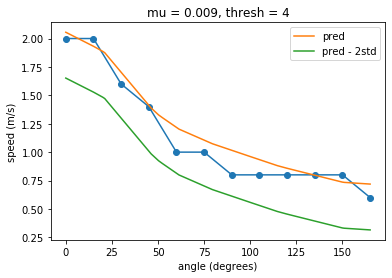

In [17]:
# plot speed vs angle given mu, threshold
mu = 0.009 # set mu
thresh = 4 # set threshold

# bug: mu = 0.009 is read as 0.0090..01
#plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == thresh] # x, y
# this is not generic enough...
pred_x = [[mu,angle,thresh] for angle in np.linspace(0,165,165)]
pred = prediction_model.predict(pred_x)

plt.title('mu = %s, thresh = %s' % (mu, thresh))
plt.xlabel('angle (degrees)')
plt.ylabel('speed (m/s)')
#plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
plt.plot([i[1] for i in plot_x], [y[i][1] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == thresh], marker='o')
plt.plot([i[1] for i in pred_x], pred[...,1]+subtract_value, label='pred') # change this to an actual prediction
plt.plot([i[1] for i in pred_x], pred[...,1], label='pred - 2std')
plt.legend()

In [20]:
prediction_model.save("gaussian_prediction_network.h5")

Make a lot of plots

In [21]:
# # only plot the high prediction...
# mus = data['mu'].unique()
# angles = data['angle'].unique()
# thresholds = data['threshold'].unique()
# a=0
# # plot speed vs angle given mu, threshold
# for mu in mus:
#     for threshold in thresholds:
#         # bug: mu = 0.009 is read as 0.0090..01
#         #plot_values = [i for i in x if i[0] == mu and i[2] == thresh] # x, y
#         plot_x = [i for i in x if np.isclose(i[0], mu) and i[2] == threshold] # x, y
#         pred_x = [[mu,angle,threshold] for angle in np.linspace(angles.min(),angles.max(),angles.max())]
#         pred = full_model.predict(pred_x)
#         #plt.plot([i[1] for i in plot_values], [y[i] for i,v in enumerate(x) if v[0] == mu and v[2] == thresh])
#         fig = plt.figure()
#         plt.title('mu: %.3f, threshold: %.2f' % (mu, threshold))
#         plt.plot([i[1] for i in plot_x], [y[i][1] for i,v in enumerate(x) if np.isclose(v[0], mu) and v[2] == threshold],
#                 label = 'training')
#         plt.plot([i[1] for i in pred_x], [i[1] for i in pred], label = 'predicted')
#         plt.legend()
#         plt.savefig('plots/mu-%.3f_threshold-%.2f.png' % (mu,threshold))
#         plt.close()

In [22]:
## weights
# fig = plt.figure()
# plt.subplot(2, 2, 1)
# plt.hist(full_model.layers[2].get_weights()[2][0])
# plt.subplot(2, 2, 2)
# plt.hist(full_model.layers[2].get_weights()[2][1])
# plt.subplot(2, 2, 3)
# plt.hist(full_model.layers[2].get_weights()[2][2])
# plt.show()